# vLife Virtusa

# Blood Cell Inception Use Case
 

### Usecase Description

#### The Patient will upload the image of a blood sample and keras model will detect and classify blood cell subtypes based on the  characteritics of patient's blood samples.

### Data Source

#### Data for Blood Cell Inception available [here](https://www.kaggle.com/paultimothymooney/blood-cells)

### Dataset Description

_This dataset contains 12,500 augmented images of blood cells (JPEG) with accompanying cell type labels (CSV). There are approximately 3,000 images for each of 4 different cell types grouped into 4 different folders (according to cell type). The cell types are Eosinophil, Lymphocyte, Monocyte, and Neutrophil. This dataset is accompanied by an additional dataset containing the original 410 images (pre-augmentation) as well as two additional subtype labels (WBC vs WBC) and also bounding boxes for each cell in each of these 410 images (JPEG + XML metadata). More specifically, the folder 'dataset-master' contains 410 images of blood cells with subtype labels and bounding boxes (JPEG + XML), while the folder 'dataset2-master' contains 2,500 augmented images as well as 4 additional subtype labels (JPEG + CSV). There are approximately 3,000 augmented images for each class of the 4 classes as compared to 88, 33, 21, and 207 images of each in folder 'dataset-master'._


### Import Neccessary Packages and Libraries


In [2]:
import numpy as np
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Input, Softmax, Activation, Flatten
from keras.models import Model
from keras import optimizers
from keras.layers import concatenate,AveragePooling2D
import os
import cv2
import scipy
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Load Data

In [29]:
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = cv2.resize(img_file, dsize=(80, 60), interpolation=cv2.INTER_CUBIC)

                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('data/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('data/dataset2-master/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
print(dict_characters)
print(dict_characters2)

100%|██████████| 620/620 [00:00<00:00, 759.33it/s]

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


In [4]:
print("Train X Shape --> ",X_train.shape)
print("Train y Shape --> ",y_trainHot.shape)
print("Train z Shape --> ",z_trainHot.shape)
##
# Input Layer (-1, 60, 80, 3) All three channel RGB
# Output Layer 1 (-1, 5) Softmax
# Output Layer 2 (-1, 2) Softmax (Doesn't work as 2nd output backpropogation messes all the weights)
##

Train X Shape -->  (9957, 60, 80, 3)
Train y Shape -->  (9957, 5)
Train z Shape -->  (9957, 2)


### Define Keras Model

In [5]:
def keras_model(block_num=2):
    inp = Input(shape=(60,80,3))
    k = BatchNormalization()(inp)
    k = Conv2D(32, (7,7), padding="same",activation="relu",strides=(2,2))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(k) 
    k = Conv2D(32, (3,3), padding="same",activation="relu",strides=(1,1))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(k)
    for j in range(1,block_num+1):
        out_conv = []
        for i in [(1,1),(3,3),(5,5),(0,0)]:
            p = k
            if i == (1,1):
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            elif i == (0,0):
                p = MaxPool2D(pool_size=(2, 2), padding="same",strides=(1,1))(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            else:
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                p = Conv2D(32, i, padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, i, padding="same",activation="relu")(p))
        x = concatenate(out_conv, axis = -1)
        #if j%2 == 0:
        #    x = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(x)
        #x = BatchNormalization(axis=-1)(x)
        k = x
   # x = Dropout(0.5)(k)
    x = MaxPool2D(pool_size=(7, 7), padding="same",strides=(2,2))(x)
    x = Flatten()(x)
    #x = Dense(1024,activation="relu")(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    y = Dense(5,activation="softmax")(x)
#    z = Dense(2,activation="softmax")(x)
    model = Model(inp, y)
    opt = optimizers.Adam(lr=0.01,decay=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    return model
model = keras_model(4)
model.summary()















__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 80, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 60, 80, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 40, 32)   4736        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 15, 20, 32)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________________

### Model Architecture 

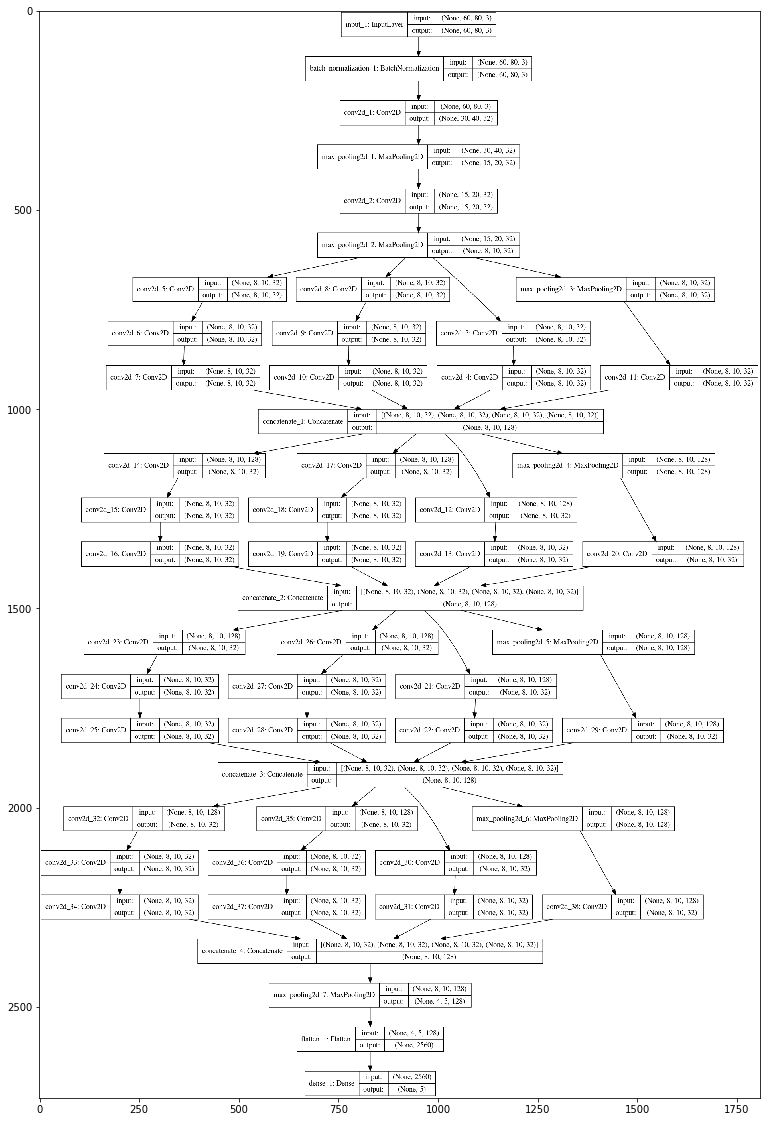

In [6]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(16,20))
plt.imshow(plt.imread('model_plot.png'))

### Train the model

In [7]:
filepath = "model/weight_tr5.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train,
         y_trainHot,
         epochs = 20,
         batch_size = 32,
         validation_data = (X_test,y_testHot),
         callbacks = callbacks_list,
         verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 9957 samples, validate on 2487 samples
Epoch 1/20
9957/9957 [==============================] - 19s 2ms/step - loss: 1.2201 - acc: 0.3689 - val_loss: 0.9201 - val_acc: 0.5107

Epoch 00001: val_acc improved from -inf to 0.51066, saving model to model/weight_tr5.hdf5
Epoch 2/20
9957/9957 [==============================] - 14s 1ms/step - loss: 0.6977 - acc: 0.6627 - val_loss: 0.5923 - val_acc: 0.7025

Epoch 00002: val_acc improved from 0.51066 to 0.70245, saving model to model/weight_tr5.hdf5
Epoch 3/20
9957/9957 [==============================] - 12s 1ms/step - loss: 0.4957 - acc: 0.7484 - val_loss: 0.5711 - val_acc: 0.7246

Epoch 00003: val_acc improved from 0.70245 to 0.72457, saving model to model/weight_tr5.hdf5
Epoch 4/20
9957/9957 [==============================] - 12s 1ms/step - loss: 0.4379 - acc: 0.7925 - val_loss: 0.8562 - val_acc: 0.6936

Epoch 00004: val_acc did not improve

### Evaluation Graphs

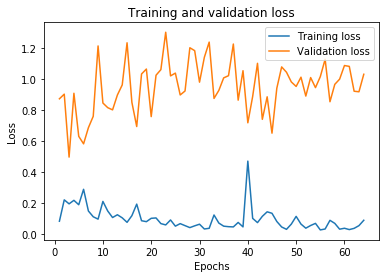

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

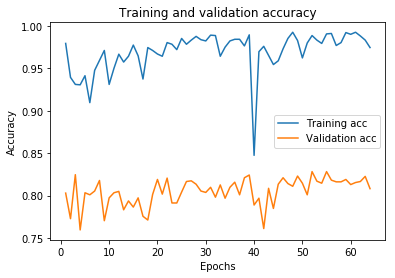

In [14]:
#Accuracy Plot
history_dict = history.history
history_dict.keys()
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Loading Best Weights from the Image generator
 

In [10]:
## Loading Best Weights from the Gang
model.load_weights(filepath)
from keras.preprocessing.image import ImageDataGenerator
datagentrain = ImageDataGenerator(featurewise_center=False,
                samplewise_center=False,
                featurewise_std_normalization=False,
                samplewise_std_normalization=False,
                zca_whitening=False, zca_epsilon=1e-06,
                rotation_range=5, width_shift_range=0.0,
                height_shift_range=0.0, brightness_range=None,
                shear_range=0, zoom_range=0.0,
                channel_shift_range=0.0, fill_mode='nearest',
                cval=0.0, horizontal_flip=True, vertical_flip=True,
                rescale=None, preprocessing_function=None,
                data_format=None, validation_split=0.0)
datagentrain.fit(X_train)
history = model.fit_generator(datagentrain.flow(X_train, y_trainHot, batch_size=32),
                    steps_per_epoch=64,
                    epochs=64,
                    workers=4,
                    use_multiprocessing=True,validation_data = (X_test,y_testHot),
         callbacks = callbacks_list,)

Epoch 1/64


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


64/64 [==============================] - 3s 51ms/step - loss: 0.0828 - acc: 0.9795 - val_loss: 0.8721 - val_acc: 0.8030

Epoch 00001: val_acc did not improve from 0.81986
Epoch 2/64
64/64 [==============================] - 3s 47ms/step - loss: 0.2205 - acc: 0.9395 - val_loss: 0.9020 - val_acc: 0.7728

Epoch 00002: val_acc did not improve from 0.81986
Epoch 3/64
64/64 [==============================] - 3s 47ms/step - loss: 0.1947 - acc: 0.9312 - val_loss: 0.4961 - val_acc: 0.8247

Epoch 00003: val_acc improved from 0.81986 to 0.82469, saving model to model/weight_tr5.hdf5
Epoch 4/64
64/64 [==============================] - 3s 47ms/step - loss: 0.2174 - acc: 0.9307 - val_loss: 0.9078 - val_acc: 0.7595

Epoch 00004: val_acc did not improve from 0.82469
Epoch 5/64
64/64 [==============================] - 3s 46ms/step - loss: 0.1890 - acc: 0.9414 - val_loss: 0.6299 - val_acc: 0.8034

Epoch 00005: val_acc did not improve from 0.82469
Epoch 6/64
64/64 [==============================] - 3s 46m


Epoch 00045: val_acc did not improve from 0.82469
Epoch 46/64
64/64 [==============================] - 3s 46ms/step - loss: 0.0809 - acc: 0.9731 - val_loss: 0.9405 - val_acc: 0.8211

Epoch 00046: val_acc did not improve from 0.82469
Epoch 47/64
64/64 [==============================] - 3s 46ms/step - loss: 0.0456 - acc: 0.9854 - val_loss: 1.0777 - val_acc: 0.8142

Epoch 00047: val_acc did not improve from 0.82469
Epoch 48/64
64/64 [==============================] - 3s 47ms/step - loss: 0.0303 - acc: 0.9927 - val_loss: 1.0435 - val_acc: 0.8110

Epoch 00048: val_acc did not improve from 0.82469
Epoch 49/64
64/64 [==============================] - 3s 47ms/step - loss: 0.0640 - acc: 0.9829 - val_loss: 0.9809 - val_acc: 0.8231

Epoch 00049: val_acc did not improve from 0.82469
Epoch 50/64
64/64 [==============================] - 3s 46ms/step - loss: 0.1139 - acc: 0.9624 - val_loss: 0.9518 - val_acc: 0.8146

Epoch 00050: val_acc did not improve from 0.82469
Epoch 51/64
64/64 [===============

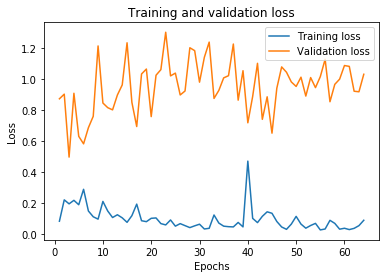

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

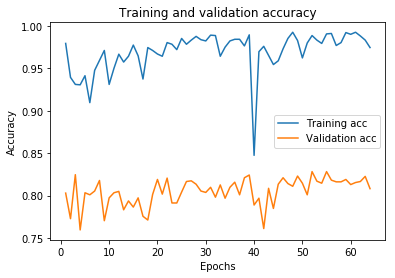

In [12]:
#Accuracy Plot
history_dict = history.history
history_dict.keys()
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Save Model

In [15]:
model.save("BloodCell_model.h5")

### Model Prediction

In [21]:
y_pred = model.predict(X_test)

In [27]:
y_pred

array([6.4660879e-19, 3.0548758e-08, 1.0000000e+00, 1.7209214e-08,
       2.3888115e-08], dtype=float32)

## END